*Training of ANN model and saving model parameters as a .gdx file for use in GAMS*
Citation : Tanuj Karia 

## Importing relevent libraries

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import tempfile

np.set_printoptions(precision=3, suppress=True)

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
print(tf.version.VERSION)


#sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.decomposition import PCA

#undersampling
from imblearn.under_sampling import RandomUnderSampler, NearMiss, AllKNN, ClusterCentroids


#optuna
#import optuna
#print(optuna.__version__)


#other
import random 
import sys
import os
import inspect


2.12.0


## Seeding:
This is to ensure the same results are achieved each time this file is ran

In [3]:
#https://stackoverflow.com/questions/45230448/how-to-get-reproducible-result-when-running-keras-with-tensorflow-backend
#https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds

def seeding(seed):
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.compat.v1.set_random_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
seeding(12)

## Dataset

In [4]:
####################importing data#####################
url = "https://github.com/kainath56/researchproject/raw/main/dataset_binarymixture_final.xlsx"
raw_dataset = pd.read_excel(url)
dataset = raw_dataset.copy()
print(dataset.head())

###########################data cleanup#################
dataset = dataset.dropna()
ds1 = dataset.drop(columns=['Unnamed: 0','Solvent 1','Solvent 2', 'T'])
print(ds1.head())
print(ds1.shape)

######################features labels###################
features = ds1.copy()
lab = features.pop('ismisc')
print(f"total {len(lab)} \n 1s {np.count_nonzero(lab == 1)} \n 0s {np.count_nonzero(lab == 0)}")
print(features.describe().transpose())




#################train_val_test split###########################
train_features, test_features, train_lab, test_lab = train_test_split(features, lab, test_size=0.15, stratify=lab, random_state=12)
train_features, val_features, train_lab,  val_lab = train_test_split(train_features, train_lab, test_size=len(test_features)/len(train_features), stratify=train_lab, random_state=12)


###################preprocessing##############################
normalizer = tf.keras.layers.Normalization(axis=-1)
np_train_features = np.asarray(train_features).astype('float64')
normalizer.adapt(np_train_features)
print(normalizer.mean.numpy())
print(train_features.shape)

   Unnamed: 0 Solvent 1 Solvent 2     q1     q2      r1      r2        x1  \
0           0  methanol   ethanol  1.432  2.588  1.4311  2.5755  0.312852   
1           1  methanol   ethanol  1.432  2.588  1.4311  2.5755  0.362349   
2           2  methanol   ethanol  1.432  2.588  1.4311  2.5755  0.507916   
3           3  methanol   ethanol  1.432  2.588  1.4311  2.5755  0.044826   
4           4  methanol   ethanol  1.432  2.588  1.4311  2.5755  0.255614   

         x2    T  ismisc  
0  0.132230  300       1  
1  0.564846  300       1  
2  0.181390  300       1  
3  0.656056  300       1  
4  0.554332  300       1  
      q1     q2      r1      r2        x1        x2  ismisc
0  1.432  2.588  1.4311  2.5755  0.312852  0.132230       1
1  1.432  2.588  1.4311  2.5755  0.362349  0.564846       1
2  1.432  2.588  1.4311  2.5755  0.507916  0.181390       1
3  1.432  2.588  1.4311  2.5755  0.044826  0.656056       1
4  1.432  2.588  1.4311  2.5755  0.255614  0.554332       1
(18432, 7)
tota

## functions for later

In [5]:
################some functions that are used elsewhere#######################

def get_mcc(tp,tn,fp,fn):
    prod1 = tp*tn
    prod2 = fp*fn
    sum1 = tp+fp
    sum2 = tp+fn
    sum3 = tn+fp
    sum4 = tn+fn
    if sum1 == 0 or sum2 == 0 or sum3==0 or sum4==0:
        return (prod1 - prod2)
    else:
        return (prod1 - prod2)/math.sqrt(sum1*sum2*sum3*sum4)
    
def neurons_upper_bound(num_train, num_inputs, num_outputs):
    num_train_eq = num_train * num_outputs
    num_neurons_ub = -1 + math.ceil((num_train_eq - num_outputs)/(num_inputs + num_outputs + 1))
    num_neurons_ub = math.floor(num_neurons_ub/3) #heuristic
    return num_neurons_ub

def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_loss_max = max(train_loss)
    val_loss_max = max(val_loss)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.ylim([0,0.1])
    #plt.ylim([0,min(train_loss_max,val_loss_max)])
    plt.xlabel('Epoch')
    plt.ylabel('Error [misc12]')
    plt.legend()
    plt.grid(True)

## Hyperparameter tuning with Optuna

def objective(trial):
    lr = trial.suggest_float('lr', 0.001, 0.1)
    ds = trial.suggest_float('ds', 400, 1200 )
    neurons=trial.suggest_int('num_neurons', 4,5)
    lreg=trial.suggest_float('lreg', 0.000001, 0.0001)
    bs= trial.suggest_int('batch_size', 1000, 2000)
    ep=trial.suggest_int('epochs', 150, 300)
    
    

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    lr,
    decay_steps=ds,
    decay_rate=1,
    staircase=False)
    

        
    model = keras.Sequential([
                normalizer,
                layers.Dense(neurons, activation='tanh', 
                             kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(l=lreg)),
                layers.Dense(1, activation='sigmoid')
            ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                          optimizer=tf.keras.optimizers.Adam(lr_schedule),
                         metrics = [
                tf.keras.metrics.TruePositives(name='tp'),
                tf.keras.metrics.FalsePositives(name='fp'),
                tf.keras.metrics.TrueNegatives(name='tn'),
                tf.keras.metrics.FalseNegatives(name='fn')])

    model.fit(
                    train_features, train_lab,
                    batch_size = bs,
                    epochs = ep,
                    verbose = 0,
                    validation_data = (val_features, val_lab)
                    )
    test_loss, tp,fp,tn,fn = model.evaluate(test_features, test_lab)
    mcc = get_mcc(tp,tn,fp,fn)
    return mcc  
sampler = optuna.samplers.TPESampler(seed=12)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective,n_trials=100)


print(study.best_params)


In [6]:
#params= {'lr': 0.0993552939293488, 'ds': 1145.5945994114088, 'num_neurons': 4, 'lreg': 3.7231439447635585e-05, 'batch_size': 1190, 'epochs': 200}
params =  {'lr': 0.09270508200753827, 'ds': 580.7432952038364, 'num_neurons': 4, 'lreg': 5.0204404985238108e-06, 'batch_size': 1067, 'epochs': 275}

lr = params['lr']
ds = params['ds']
lreg= params['lreg']
bs= params['batch_size']
ep=params['epochs']




## Iterative training: 
Method of determining the ***minimum*** number of neurons required to obtain MCC=0.9  

In [7]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    lr,
    decay_steps=ds,
    decay_rate=1,
    staircase=False
)


def build_and_compile_model_single_layer(norm,num_neurons,activation='tanh',output_bias=None):
    if activation =='relu':
        kernel_initializer = 'he_normal'
    else:
        kernel_initializer = 'glorot_uniform'
        
    if output_bias is not None:
        output_biasias = tf.kernel_initializers.Constant(output_bias)
        
        
    
    model = keras.Sequential([
        norm,
        layers.Dense(num_neurons, activation=activation, 
                     kernel_initializer=kernel_initializer, kernel_regularizer=tf.keras.regularizers.l2(l=lreg)),
        layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(lr_schedule),
                 metrics = [
        tf.keras.metrics.BinaryCrossentropy(name='binary_crossentropy'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        #tf.keras.metrics.Precision(name='precision'),
        #tf.keras.metrics.Recall(name='recall'),
        #tf.keras.metrics.AUC(name='AUC'),
        #tf.keras.metrics.AUC(name='prc', curve='PR'),
            ]
                 )
    return model

def iterative_training(norm, num_train, num_inputs,
                       num_outputs, activation, num_epochs, 
                       train_features, train_labels,
                       val_features, val_labels,
                       test_features, test_labels, tolerance):
    num_neurons_ub = neurons_upper_bound(num_train, num_inputs, num_outputs)
    mcc = {}
    max_value = 0
    for i in range(6, num_neurons_ub):
        seeding(30*i**2+40*i+50)
        sums =0
        count = 0
        for j in range(1,6):
            seeding(300*j**2+400*j+500)
            print("Number of neurons: ",i," Trial ", j)  
            model = build_and_compile_model_single_layer(norm,i,activation)
            
            history = model.fit(
            train_features,
            train_labels,
            batch_size = bs,
            epochs = ep,
            verbose = 0,
            validation_data = (val_features, val_lab)
            )
            mcc[i,j] = get_mcc(history.history['val_tp'][num_epochs-1], history.history['val_tn'][num_epochs-1], history.history['val_fp'][num_epochs-1], history.history['val_fn'][num_epochs-1])
            print(mcc[i,j])
            if (mcc[i,j] > max_value):
                max_value = mcc[i,j]
                best_model = model
                best_history = history                
            sums+=mcc[i,j]
            count+=1
            if max_value>=tolerance:
                break
        #max_value = max(mcc.values())
        print("Max mcc so far", max_value)
        print(f"Average for {i} neurons is {sums/count}")
        if max_value >= tolerance:
            #max_key = max(mcc, key=mcc.get)
            #print(max_key)
            return best_model, best_history, max_value
            break
        else:
            continue
        

In [8]:
num_outputs = 1
num_inputs = len(train_features.columns) - num_outputs
num_train = len(train_features)

In [9]:
%%time
tanh_model, tanh_history, tanh_mcc = iterative_training(
    normalizer, num_train, 
    num_inputs, num_outputs,
    'tanh' , ep, train_features, train_lab, 
    val_features, val_lab, 
    test_features, test_lab, 0.99)

Number of neurons:  6  Trial  1
0.9809783950075025
Number of neurons:  6  Trial  2
0.9828901589648834
Number of neurons:  6  Trial  3
0.988623067124935
Number of neurons:  6  Trial  4
0.9847997507922022
Number of neurons:  6  Trial  5
0.990515637606155
Max mcc so far 0.990515637606155
Average for 6 neurons is 0.9855614018991355
CPU times: total: 1min 2s
Wall time: 2min 32s


In [36]:
tanh_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 6)                 42        
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 62
Trainable params: 49
Non-trainable params: 13
_________________________________________________________________


## Results

In [37]:
test_results = {}
test_results['tanh_model'] = tanh_model.evaluate(test_features, test_lab)
print(test_results)

get_mcc(2468,295,1,1)

87/87 [==============================] - 1s 4ms/step - loss: 0.0030 - binary_crossentropy: 0.0023 - accuracy: 0.9993 - tp: 2468.0000 - fp: 1.0000 - tn: 295.0000 - fn: 1.0000    
{'tanh_model': [0.0030276428442448378, 0.0022529016714543104, 0.9992766976356506, 2468.0, 1.0, 295.0, 1.0]}


0.9962165993453964

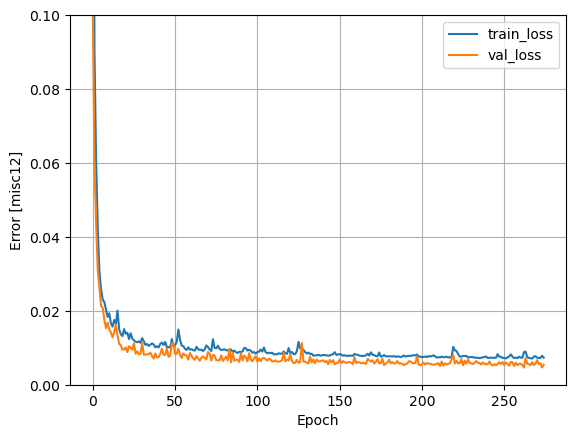

In [12]:
plot_loss(tanh_history)

In [13]:
ds2 = ds1.copy()
ismisc_full = ds2.pop('ismisc')
tot_neg, tot_pos = np.bincount(ismisc_full)
total_full = tot_neg + tot_pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total_full, tot_pos, 100 * tot_pos / total_full, tot_neg, 100 * tot_neg / total_full))

Examples:
    Total: 18432
    Positive: 16457 (89.28% of total)
    Negative: 1975 (10.72% of total)



In [14]:
tanh_test_predictions = tanh_model.predict(test_features).flatten()
tanh_val_predictions = tanh_model.predict(val_features).flatten()
tanh_train_predictions = tanh_model.predict(train_features).flatten()

tanh_predictions = tanh_model.predict(ds2).flatten()

bool_labels = ismisc_full != 0
pos_pred = pd.DataFrame(tanh_predictions[bool_labels])
neg_pred = pd.DataFrame(tanh_predictions[~bool_labels])

576/576 [==============================] - 1s 2ms/step


(array([    2.,     0.,     2.,     0.,     0.,     0.,     0.,     0.,
            2.,    18.,    13.,     4.,     4.,     7.,     6.,     3.,
           10.,    17.,    22., 16347.]),
 array([0.011, 0.06 , 0.11 , 0.159, 0.209, 0.258, 0.308, 0.357, 0.406,
        0.456, 0.505, 0.555, 0.604, 0.654, 0.703, 0.753, 0.802, 0.852,
        0.901, 0.951, 1.   ]),
 <BarContainer object of 20 artists>)

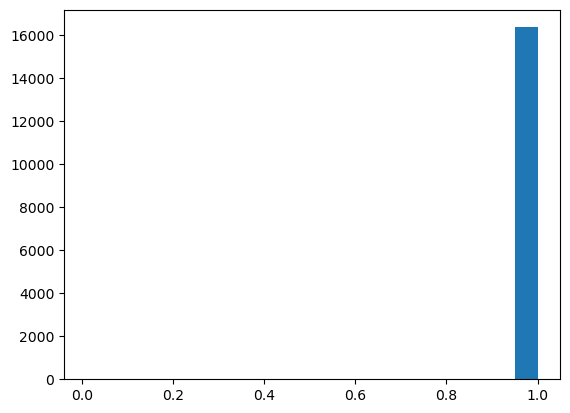

In [15]:
plt.hist(pos_pred,20)

(array([1845.,   45.,   18.,    6.,    6.,    5.,    2.,    1.,    0.,
           1.,    0.,    6.,   13.,    7.,    8.,    5.,    2.,    2.,
           1.,    2.]),
 array([0.   , 0.038, 0.075, 0.113, 0.151, 0.188, 0.226, 0.264, 0.301,
        0.339, 0.377, 0.414, 0.452, 0.49 , 0.527, 0.565, 0.603, 0.64 ,
        0.678, 0.716, 0.753]),
 <BarContainer object of 20 artists>)

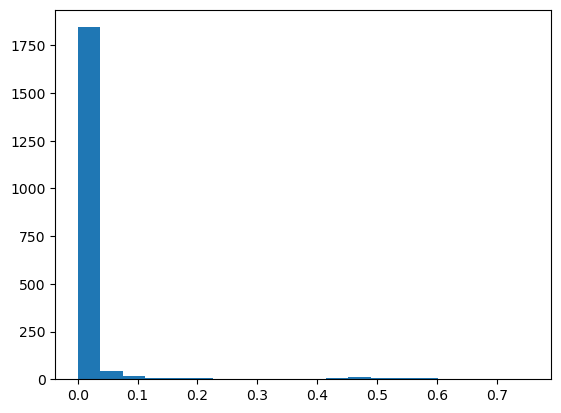

In [16]:
plt.hist(neg_pred,20)

In [17]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Immiscible samples correctly classified (True Negatives): ', cm[0][0])
    print('Immiscible samples incorrectly classified (False Positives): ', cm[0][1])
    print('Miscible samples incorrectly classified (False Negatives): ', cm[1][0])
    print('Miscible samples correctly classified (True Positives): ', cm[1][1])
    print('Total Miscible samples: ', np.sum(cm[1]))
    return cm

In [18]:
pd_predictions = pd.Series(tanh_predictions)

In [19]:
pd_predictions.describe()

count    1.843200e+04
mean     8.928048e-01
std      3.055203e-01
min      3.634358e-14
25%      9.999998e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [20]:
np.histogram(tanh_predictions)

(array([ 1908,    17,     7,     1,    37,    38,    16,    12,    27,
        16369], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

<Axes: ylabel='Frequency'>

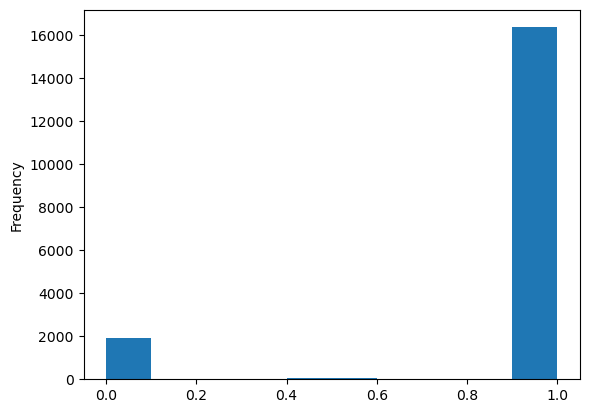

In [21]:
pd_predictions.plot(kind='hist')

<Axes: ylabel='Frequency'>

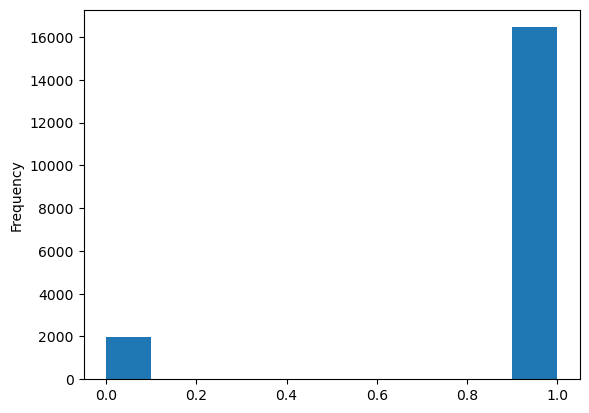

In [22]:
pd_ismisc = pd.Series(ismisc_full)
pd_ismisc.plot(kind='hist')

In [23]:
from sklearn.metrics import confusion_matrix 

In [35]:
def classifier_performance(num_points, predictions, lab):
    p = np.arange(0,1,1/num_points)
    precision = np.empty([num_points,])
    recall = np.empty([num_points,])
    accuracy = np.empty([num_points,])
    f1score = np.empty([num_points,])
    mcc = np.empty([num_points,])
    for indexp, pi in np.ndenumerate(p):
        cm = confusion_matrix(lab, predictions > pi)
        precision[indexp] = (cm[1][1]/(cm[1][1] + cm[0][1]))
        recall[indexp] = (cm[1][1]/(cm[1][1] + cm[1][0]))
        accuracy[indexp] = ((cm[1][1]+cm[0][0])/(cm[1][1] + cm[1][0] + cm[0][0] + cm[0][1]))
        f1score[indexp] = (2*precision[indexp]*recall[indexp]/(precision[indexp] + recall[indexp]))
        mcc[indexp] = get_mcc(cm[1][1],cm[0][0],cm[0][1],cm[1][0])
    return p, precision, recall, accuracy, f1score, mcc
df = pd.DataFrame([p, mcc])
df.to_csv('tanh_bin.csv')

In [33]:
def plot_performance(p,prec, rec, acc, f1score, mcc):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    
    ax1.plot(p,prec, color='r', label='precision')
    ax1.plot(p,rec, color='b', label='recall')
    ax1.plot(p,acc, color='black', label='accuracy')
    ax1.set_ylabel('Metric value')
    ax1.set_xlabel('Probability')
    ax1.set_xticks(np.arange(0,1.1,0.1))
    ax1.legend()
    
    ax = ax2.twinx()
    ax2.plot(p,f1score, color='orange', label='F1 score')
    ax.plot(p,mcc, color='black', label='MCC')
    ax2.set_ylabel('Metric value')
    ax2.set_xlabel('Probability')
    ax2.set_xticks(np.arange(0,1.1,0.1))
    plt.legend(loc='lower right')
    
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Create the combined legend
    ax.legend(handles1 + handles2,  labels1 + labels2, loc='lower right')
    
    plt.show()

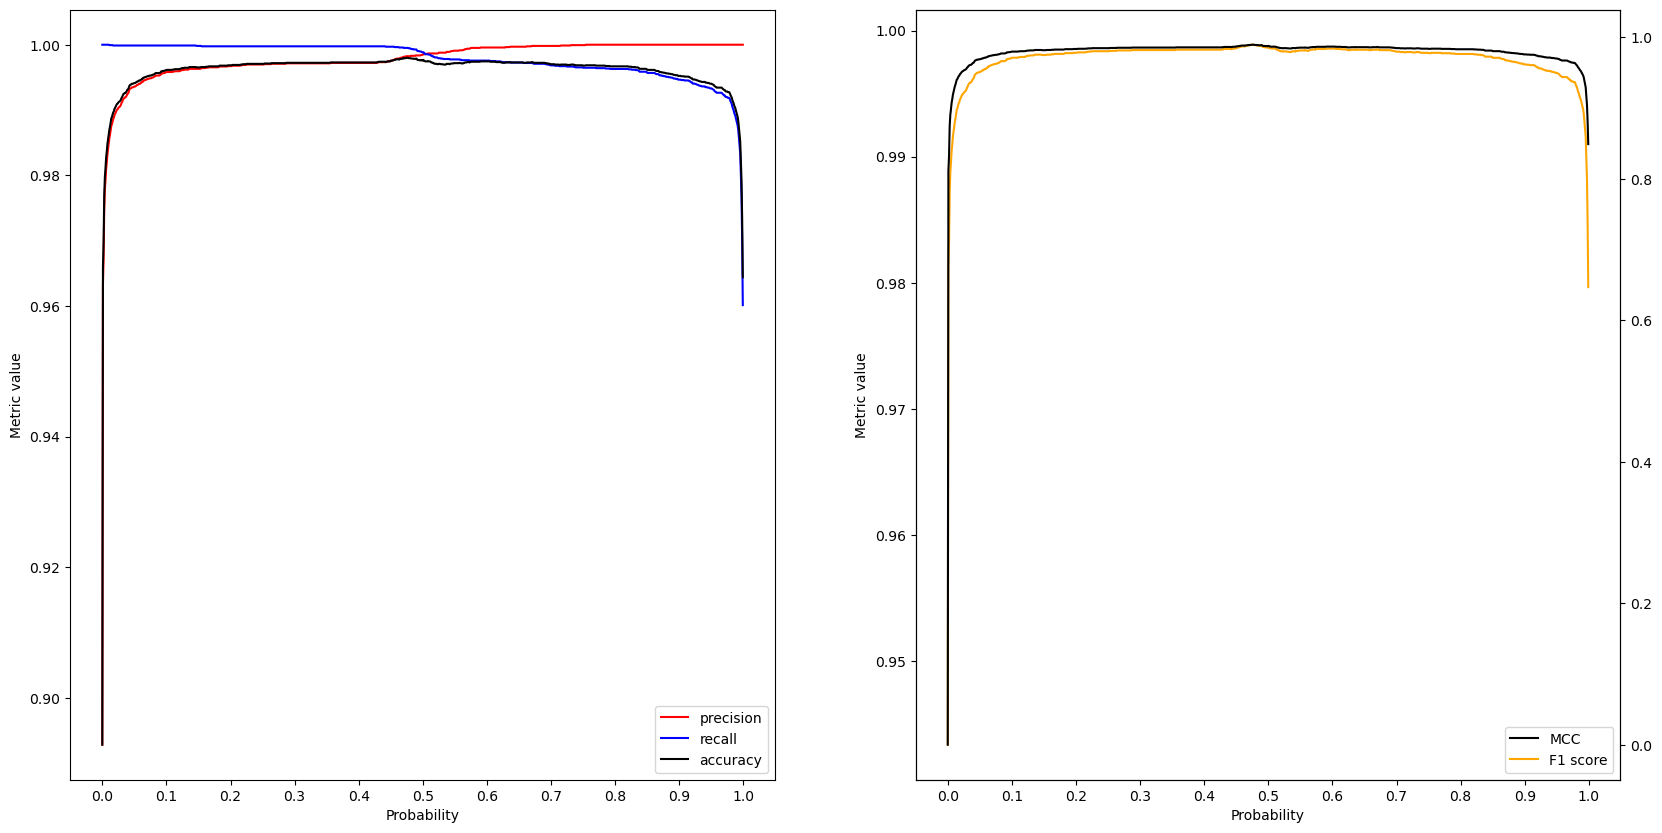

In [34]:
p, precision, recall, accuracy, f1score, mcc = classifier_performance(1000, tanh_predictions, ismisc_full)
plot_performance(p,precision,recall,accuracy,f1score, mcc)

In [27]:
print('Accuracy: ', max(accuracy), np.argmax(accuracy))
print('F1 score: ', max(f1score), np.argmax(f1score))
print('MCC: ', max(mcc), np.argmax(mcc))
print('Precision: ', max(precision), np.argmax(precision))

Accuracy:  0.9979926215277778 474
F1 score:  0.9988765750721117 474
MCC:  0.989477163331941 474
Precision:  1.0 754


In [28]:
tanh_model.save('1c_tanh_binary_optuna')

INFO:tensorflow:Assets written to: 1c_tanh_binary_optuna\assets


INFO:tensorflow:Assets written to: 1c_tanh_binary_optuna\assets


# TRANSFER TO GAMS

In [ ]:
%reload_ext gams_magic
%gams_cleanup  -k

In [ ]:
pwd = os.getcwd()
pardir = os.path.abspath(os.path.join(pwd, os.pardir))
print(pardir)

path = os.path.join(pwd, '1c_tanh_binary_optuna')
#tanh_path = os.path.join(pardir,'tanh_model_ib_noT_miL2')
#relu_path = os.path.join(pardir,'relu_model_ib_noT_miL2')
#rbf_path = os.path.join(pardir,'rbf_model_ib_noT_miL2')

tanh_model = tf.keras.models.load_model(path, compile=False)
tanh_model.summary()

In [ ]:
weights = tanh_model.get_weights()

print(weights)

mean = weights[0]
sd = weights[1]**0.5

print(mean)
print(sd)

input_gain = 1/sd
input_offset = mean
print(input_gain)
print(input_offset)

num_inputs = len(input_gain)
print(num_inputs)

In [ ]:
%%gams
SETS
f      'inputs to neural network' /1*6/;

In [ ]:
%%gams
SETS
hl1    'number of hidden layers' /1*6/;

In [ ]:
%%capture
%run DataTransform.ipynb

In [ ]:
%gams_pull f hl1

In [ ]:
%%gams
parameter input_offset(f), input_gain(f), bias1(hl1), wt2(hl1), wt1(f<,hl1<);

In [ ]:
print(input_offset)
%gams_push input_offset
%gams display input_offset;
%gams_lst -e
%gams_cleanup -k

In [ ]:
print(input_gain)
%gams_push input_gain
%gams display input_gain;
%gams_lst -e
%gams_cleanup -k

In [ ]:
bias1 = weights[4]
print(bias1.shape)
%gams_push bias1
%gams display bias1;
%gams_lst -e
%gams_cleanup -k

In [ ]:
%%gams
Scalar bias2;

In [ ]:
bias2 = weights[6]
bias2 = float(bias2[0])
print(bias2)

%gams_push bias2
%gams display bias2;
%gams_lst -e
%gams_cleanup -k

In [ ]:
wt2 = weights[5]
print(wt2)
print(wt2.shape)
wt2 = np.reshape(wt2, (6,))
print(wt2.shape)
%gams_push wt2
%gams display wt2;
%gams_lst -e
%gams_cleanup -k

In [ ]:
wt1 = weights[3]
print(wt1.shape)
wt1 = pd.DataFrame(index=f,columns=hl1, data=wt1)
print(wt1)
wt1 = gt_from2dim(wt1)
#print(wt1)
%gams_push wt1
%gams display wt1;
%gams_lst -e
%gams_cleanup -k